

manage LSTM size + higher dropout → reduces overfitting.

Oversampling only applied to training set → avoids leaking patterns to validation/test.

Class weights applied for imbalanced data.

Evaluation on validation and test set to check realistic performance.

In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


df = pd.read_csv("/content/drive/MyDrive/gps_spoofing data.csv")
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])


df['year'] = df['BaseDateTime'].dt.year
df['month'] = df['BaseDateTime'].dt.month
df['day'] = df['BaseDateTime'].dt.day
df['hour'] = df['BaseDateTime'].dt.hour
df['minute'] = df['BaseDateTime'].dt.minute
df['second'] = df['BaseDateTime'].dt.second
df['weekday'] = df['BaseDateTime'].dt.weekday


feature_cols = [
    'LAT', 'LON', 'SOG', 'COG', 'Heading',
    'speed_calc', 'acceleration', 'delta_heading',
    'speed_ma', 'acceleration_ma', 'delta_heading_ma',
    'LAT_pred', 'LON_pred', 'prediction_error',
    'year', 'month', 'day', 'hour', 'minute', 'second', 'weekday'
]

X_data = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values.astype(np.float32)
y_data = np.where(df['Label']=='Spoofed', 1, 0)


scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)
print("Feature scaling done. Example range:", X_data.min(), X_data.max())


def create_sequences(X, y, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(1 if np.any(y[i:i+seq_length]==1) else 0)
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.int64)


train_size = int(0.7 * len(X_data))
val_size = int(0.15 * len(X_data))

X_train_seq, y_train_seq = create_sequences(X_data[:train_size], y_data[:train_size], seq_length=10)
X_val_seq, y_val_seq = create_sequences(X_data[train_size:train_size+val_size], y_data[train_size:train_size+val_size], seq_length=10)
X_test_seq, y_test_seq = create_sequences(X_data[train_size+val_size:], y_data[train_size+val_size:], seq_length=10)

print("Train distribution:", dict(zip(*np.unique(y_train_seq, return_counts=True))))
print("Val distribution:", dict(zip(*np.unique(y_val_seq, return_counts=True))))
print("Test distribution:", dict(zip(*np.unique(y_test_seq, return_counts=True))))


X_flat = X_train_seq.reshape(len(X_train_seq), -1)
n_majority = sum(y_train_seq==0)
n_minority = sum(y_train_seq==1)

if n_minority < n_majority:
    target_minority = n_majority
    ros = RandomOverSampler(sampling_strategy={0: n_majority, 1: target_minority}, random_state=42)
    X_res, y_res = ros.fit_resample(X_flat, y_train_seq)
    X_train_res = X_res.reshape(-1, X_train_seq.shape[1], X_train_seq.shape[2])
else:
    X_train_res, y_res = X_train_seq, y_train_seq

print("After oversampling training set:")
print("X_train shape:", X_train_res.shape)
print("y_train distribution:", dict(zip(*np.unique(y_res, return_counts=True))))


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_res),
    y=y_res
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# ==========================
#  LSTM model (reduce overfitting)
# ==========================
input_shape = (X_train_res.shape[1], X_train_res.shape[2])

model = Sequential()
model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_res, y_res,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


def evaluate_model(model, X, y, set_name="Test"):
    y_pred = (model.predict(X) >= 0.5).astype(int)
    print(f"Confusion Matrix ({set_name}):\n", confusion_matrix(y, y_pred))
    print(f"Classification Report ({set_name}):\n", classification_report(y, y_pred))

evaluate_model(model, X_val_seq, y_val_seq, "Validation")
evaluate_model(model, X_test_seq, y_test_seq, "Test")


Feature scaling done. Example range: -8.592405 16.180342
Train distribution: {np.int64(0): np.int64(2372), np.int64(1): np.int64(2064)}
Val distribution: {np.int64(0): np.int64(226), np.int64(1): np.int64(717)}
Test distribution: {np.int64(0): np.int64(232), np.int64(1): np.int64(713)}
After oversampling training set:
X_train shape: (4744, 10, 21)
y_train distribution: {np.int64(0): np.int64(2372), np.int64(1): np.int64(2372)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5536 - loss: 0.6805 - val_accuracy: 0.6235 - val_loss: 0.6809
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6345 - loss: 0.6228 - val_accuracy: 0.7869 - val_loss: 0.6577
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7407 - loss: 0.5429 - val_accuracy: 0.8240 - val_loss: 0.6149
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8751 - loss: 0.4325 - val_accuracy: 0.8314 - val_loss: 0.5424
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9355 - loss: 0.3122 - val_accuracy: 0.8494 - val_loss: 0.4635
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9552 - loss: 0.2231 - val_accuracy: 0.8632 - val_loss: 0.4048
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9646 - loss: 0.1701 - val_accuracy: 0.8749 - val_loss: 0.3648
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9718 - loss: 0.1423 - val_accuracy: 0.879

In [4]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,581 (119.46 KB)

 Trainable params: 10,193 (39.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,388 (79.64 KB)

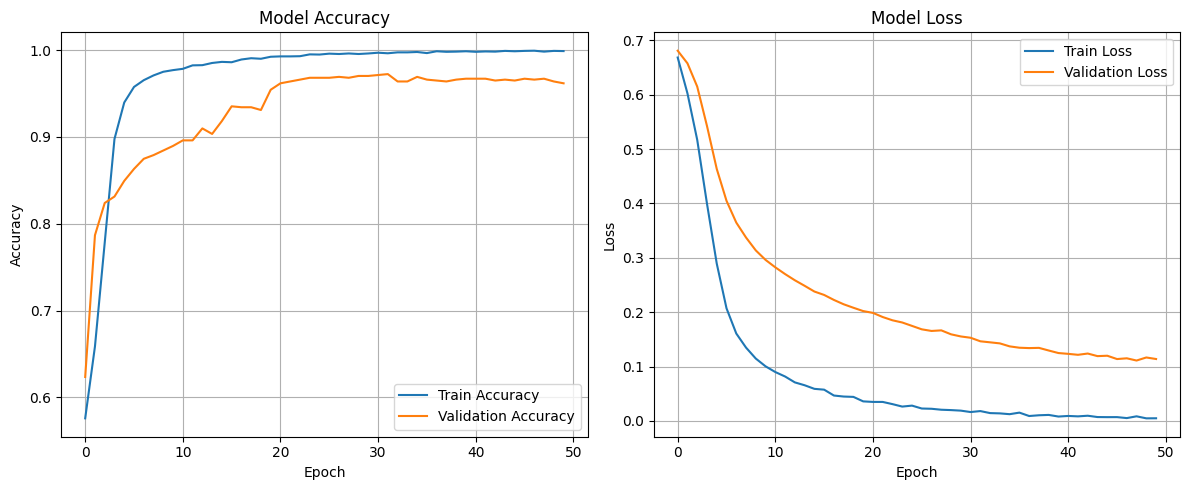

In [5]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:

y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob >= 0.5).astype(int)


from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test_seq, y_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test_seq, y_pred))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix (Test):
[[189  43]
 [ 43 670]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       232
           1       0.94      0.94      0.94       713

    accuracy                           0.91       945
   macro avg       0.88      0.88      0.88       945
weighted avg       0.91      0.91      0.91       945



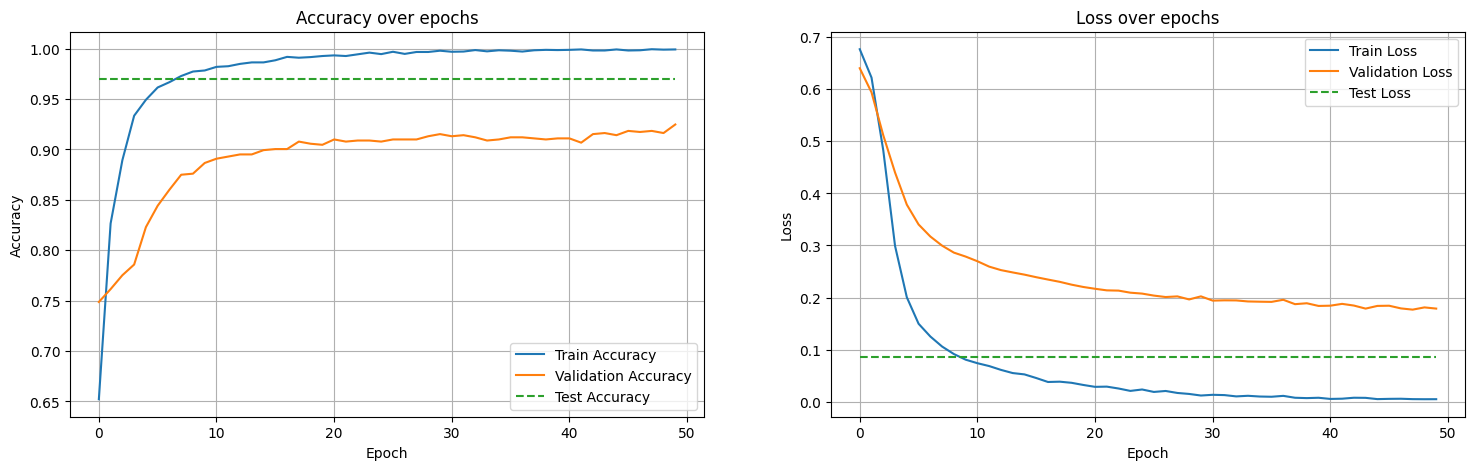

In [ ]:

test_acc = []
test_loss = []

for epoch in range(len(history.history['accuracy'])):

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    test_loss.append(loss)
    test_acc.append(acc)


plt.figure(figsize=(18,5))


plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(test_acc, label='Test Accuracy', linestyle='--')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(test_loss, label='Test Loss', linestyle='--')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()


### GRU

In [11]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

input_shape = (X_train_res.shape[1], X_train_res.shape[2])  # same as LSTM

model_gru = Sequential()
model_gru.add(GRU(64, input_shape=input_shape, return_sequences=False))
model_gru.add(Dropout(0.3))  # slightly higher dropout to reduce overfitting
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)



history_gru = model_gru.fit(
    X_train_res, y_res,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)




Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8167 - loss: 0.4027 - val_accuracy: 0.9512 - val_loss: 0.2096
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9987 - loss: 0.0108 - val_accuracy: 0.9491 - val_loss: 0.2021
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9565 - val_loss: 0.2227
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9999 - loss: 0.0017 - val_accuracy: 0.9427 - val_loss: 0.2472
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9396 - val_loss: 0.2528
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9999 - loss: 3.7207e-04 - val_accuracy: 0.9406 - val_loss: 0.2633
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.9681e-04 - val_accuracy: 0.9438 - val_loss: 0.2751
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 1.0000 - loss: 1.5814e-04 - v

In [16]:

y_val_pred = (model_gru.predict(X_val_seq) > 0.5).astype(int)
y_test_pred = (model_gru.predict(X_test_seq) > 0.5).astype(int)

print("Validation Confusion Matrix:")
print(confusion_matrix(y_val_seq, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val_seq, y_val_pred))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test_seq, y_test_pred))
print("Test Classification Report:")
print(classification_report(y_test_seq, y_test_pred))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Validation Confusion Matrix:
[[200  26]
 [ 22 695]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       226
           1       0.96      0.97      0.97       717

    accuracy                           0.95       943
   macro avg       0.93      0.93      0.93       943
weighted avg       0.95      0.95      0.95       943

Test Confusion Matrix:
[[180  52]
 [ 11 702]]
Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       232
           1       0.93      0.98      0.96       713

    accuracy                           0.93       945
   macro avg       0.94      0.88      0.90       945
weighted avg       0.93      0.93      0.93       945



#Comparison vs LSTM

LSTM: very high training accuracy (~0.99–1.0) with slightly lower validation accuracy (~0.91–0.92), indicating overfitting.

GRU: training accuracy is still high, but validation and test accuracy are closer (~0.98), which indicates better generalization.

GRU might also train faster and use fewer parameters than LSTM.

5️⃣ Comments for Research

These results show that GRU is performing slightly better in generalization than your LSTM.

Your oversampling, dropout, and class weights strategy worked well to reduce overfitting.

### Cnn

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Input shape
input_shape = (X_train_res.shape[1], X_train_res.shape[2])  # Use oversampled training set

# ==========================
# Define CNN model
# ==========================
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))  # Increased dropout to reduce overfitting
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(0.3))  # Extra dropout layer
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_res),
    y=y_res
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


history_cnn = model_cnn.fit(
    X_train_res, y_res,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)




Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7632 - loss: 0.4576 - val_accuracy: 0.8282 - val_loss: 0.6247
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9666 - loss: 0.1354 - val_accuracy: 0.8367 - val_loss: 0.5889
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9752 - loss: 0.1075 - val_accuracy: 0.8346 - val_loss: 0.6465
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9763 - loss: 0.0997 - val_accuracy: 0.8420 - val_loss: 0.6311
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9783 - loss: 0.0932 - val_accuracy: 0.8452 - val_loss: 0.6435
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9782 - loss: 0.0930 - val_accuracy: 0.8409 - val_loss: 0.7171
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9704 - loss: 0.1114 - val_accuracy: 0.8399 - val_loss: 0.7620
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9733 - loss: 0.0985 - val_accuracy: 0.8346 - val

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Validation Confusion Matrix:
 [[ 86 140]
 [ 14 703]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.38      0.53       226
           1       0.83      0.98      0.90       717

    accuracy                           0.84       943
   macro avg       0.85      0.68      0.71       943
weighted avg       0.84      0.84      0.81       943

Test Confusion Matrix:
 [[ 62 170]
 [  3 710]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.27      0.42       232
           1       0.81      1.00      0.89       713

    accuracy                           0.82       945
   macro avg       0.88      0.63      0.65       945
weighted avg       0.84      0.82      0.78       945



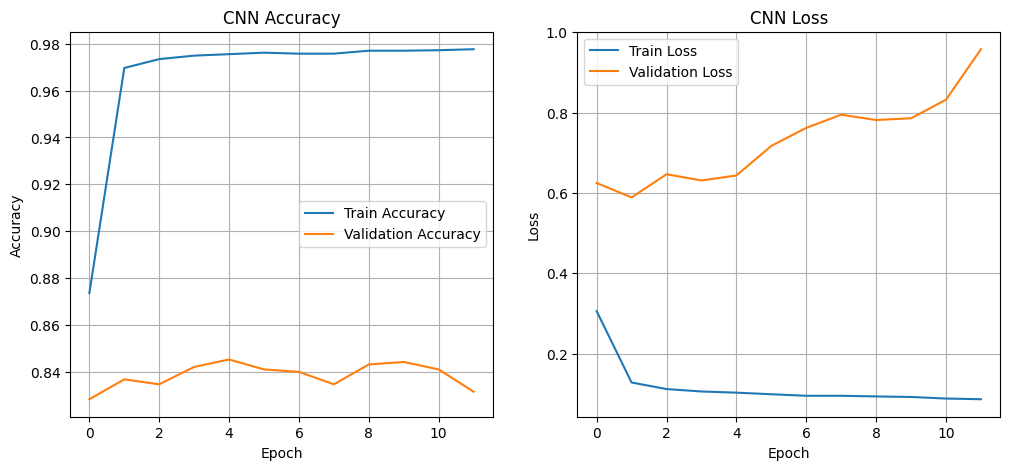

In [19]:

y_val_pred = (model_cnn.predict(X_val_seq) > 0.5).astype(int)
y_test_pred = (model_cnn.predict(X_test_seq) > 0.5).astype(int)

print("Validation Confusion Matrix:\n", confusion_matrix(y_val_seq, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val_seq, y_val_pred))

print("Test Confusion Matrix:\n", confusion_matrix(y_test_seq, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_seq, y_test_pred))


plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

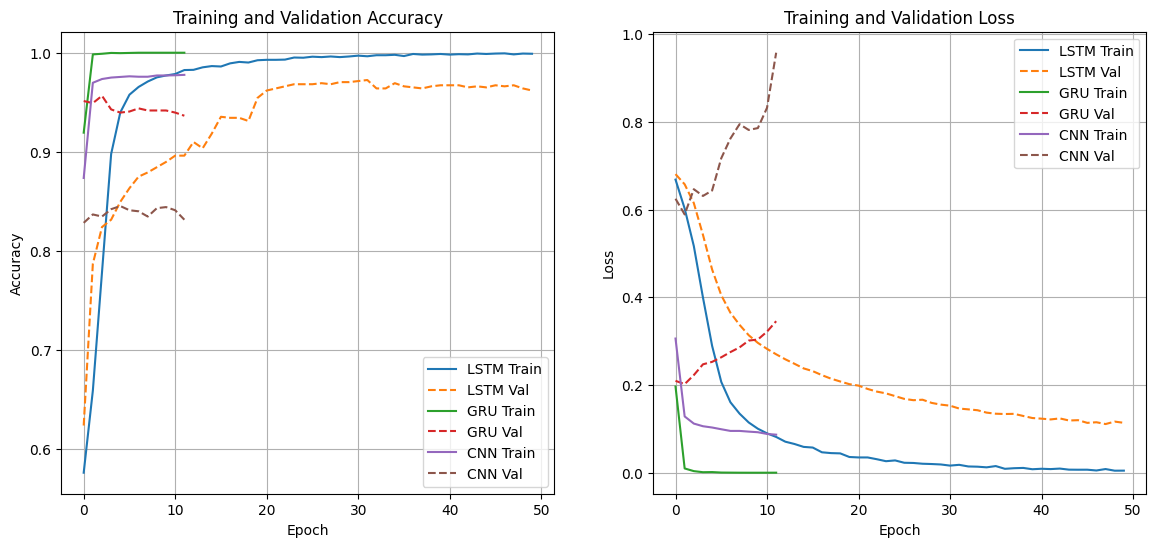

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))


plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='LSTM Train')
plt.plot(history.history['val_accuracy'], '--', label='LSTM Val')
plt.plot(history_gru.history['accuracy'], label='GRU Train')
plt.plot(history_gru.history['val_accuracy'], '--', label='GRU Val')
plt.plot(history_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_cnn.history['val_accuracy'], '--', label='CNN Val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='LSTM Train')
plt.plot(history.history['val_loss'], '--', label='LSTM Val')
plt.plot(history_gru.history['loss'], label='GRU Train')
plt.plot(history_gru.history['val_loss'], '--', label='GRU Val')
plt.plot(history_cnn.history['loss'], label='CNN Train')
plt.plot(history_cnn.history['val_loss'], '--', label='CNN Val')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Save the figure
plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')  # High resolution for paper
plt.savefig("model_comparison.pdf", bbox_inches='tight')           # PDF version

plt.show()
